In [30]:
#inicjalizacja bibliotek
import numpy as np
import pandas as pd
from sympy import symbols, Eq, solve
import matplotlib.pyplot as plt


#GUI
import tkinter as tk
from tkinter import messagebox

from tkinter import ttk

from tkinter.ttk import Combobox
from tkinter import IntVar

from tkinter import filedialog as fd

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

#Optimization
from scipy.optimize import curve_fit

In [89]:
class concentration:
    def __init__(self, Element1, Element2, concentration_Element1, total_thickness,AK_Height):
        
        self.mol_data = {"Co":6.67*10**-6, "Ni":6.59*10**-6, "Au":10.21*10**-6, "Pt":9.09*10**-6, "Tb":1.93*10**-5} # dict with molecular volume of elements
        #self.mol_data = dict(pd.read_excel("molecular_database.xlsx"))
        
        self.Element1 = str(Element1)
        self.Element2 = str(Element2)
        self.concentration_Element1 = float(concentration_Element1)
        self.total_thickness = float(total_thickness)
        self.AK_Height = str(AK_Height)
        self.load_polynomial(self.AK_Height)
        self.epsilon_calibration()
        
    def epsilon_calibration(self):
        
        tElement1, tElement2 = symbols('tElement1, tElement2')
        eq1 = Eq(100*(tElement1/self.mol_data[self.Element1])/((tElement1/self.mol_data[self.Element1]) + ((tElement2)/self.mol_data[self.Element2])),self.concentration_Element1)
        eq2 =  Eq(tElement2 + tElement1,self.total_thickness)
        solved = dict((str(key), float(value)) for (key, value) in solve((eq1,eq2),(tElement1,tElement2)).items())
        self.thickness_Element1  = solved['tElement1'] 
        self.thickness_Element2 = solved['tElement2']
        
        self.epsilon_Element1 = self.thickness_Element1/self.polynomial(65)
        self.epsilon_Element2 = self.thickness_Element2/self.polynomial(65)
        
    def load_polynomial(self,filename_poly):
        self.polynomial = np.poly1d(np.load(filename_poly))
        
    def calculate_concentration_1D(self):
        
        self.number_points = 201
        xt = 65
        xt2 = -65
        self.xsize = 20
        self.thickness_distribution_Element1 = np.zeros([self.number_points])
        self.thickness_distribution_Element2 = np.zeros([self.number_points])

        
        for lx,x in enumerate(np.linspace(-0.5*self.xsize,0.5*self.xsize,self.number_points)):
            ro = np.sqrt((x - xt)**2)
            ro2 = np.sqrt((x - xt2)**2)
            self.thickness_distribution_Element1[lx]=self.epsilon_Element1*self.polynomial(ro)
            self.thickness_distribution_Element2[lx]=self.epsilon_Element2*self.polynomial(ro2)
        self.total_thickness_distribution = self.thickness_distribution_Element1+self.thickness_distribution_Element2
        self.composition()    
    
    def calculate_concentration_2D(self):  
        self.number_points = 201
        xt = 65
        yt = 0
        xt2 = -65
        yt2 = 0
        self.xsize = 20
        self.ysize = 20
        self.thickness_distribution_Element1 = np.zeros([self.number_points,self.number_points])
        self.thickness_distribution_Element2 = np.zeros([self.number_points,self.number_points])

        
        for lx,x in enumerate(np.linspace(-0.5*self.xsize,0.5*self.xsize,self.number_points)):
            for ly,y in enumerate(np.linspace(-0.5*self.ysize,0.5*self.ysize,self.number_points)):
                ro = np.sqrt((x - xt)**2 + (y - yt)**2)
                ro2 = np.sqrt((x - xt2)**2 + (y - yt2)**2)
                self.thickness_distribution_Element1[lx,ly]=self.epsilon_Element1*self.polynomial(ro)
                self.thickness_distribution_Element2[lx,ly]=self.epsilon_Element2*self.polynomial(ro2)
        self.total_thickness_distribution = self.thickness_distribution_Element1+self.thickness_distribution_Element2
        self.composition()
        
    def composition(self):
        self.composition_distribution_Element1=100*self.thickness_distribution_Element1/self.mol_data[self.Element1]/(self.thickness_distribution_Element1/self.mol_data[self.Element1]+self.thickness_distribution_Element2/self.mol_data[self.Element2])
              
    
    def transform(self): #funckja zmieniająca tablice numpy na DataFrame
        def df_transform(data):
            df_data = pd.DataFrame(data).T
            df_data.index = np.linspace(0,self.xsize,self.number_points)
            df_data.columns = np.arange(0,self.ysize,self.number_points)
            return df_data
        
        self.composition_distribution_Element1 = df_transform(self.composition_distribution_Element1)
        self.total_thickness_distribution = df_transform(self.total_thickness_distribution)
        self.thickness_distribution_Element1 = df_transform(self.thickness_distribution_Element1)
        self.thickness_distribution_Element2 = df_transform(self.thickness_distribution_Element2)      
             
        
    def draw_figures_2D(self):
        
        self.transform()
              
        font=12
        plt.figure(0)
        plt.clf()
        data = self.composition_distribution_Element1
        plt.imshow(data, cmap='nipy_spectral',interpolation='gaussian',extent=[data.columns[0],data.columns[-1],data.columns[0],data.columns[-1]])
        plt.title(f"Concentration distribution of {self.Element1} [at.%]",fontsize=font)
        plt.xlabel("X position [mm]",fontsize=font)
        plt.ylabel("Y position [mm]",fontsize=font)
        plt.minorticks_on()
        plt.tick_params(axis="x", which = "major", length=10, direction ="in",labelsize=10)
        plt.tick_params(axis="y", which = "major", length=10, direction ="in",labelsize=10, color = "w")
        plt.tick_params(axis="x", which = "minor", length=5, direction ="in")
        plt.tick_params(axis="y", which = "minor", length=5, direction ="in", color ="w")        
        plt.colorbar()
        plt.axhline(0, linestyle ="--",color="black",linewidth=3)
        
        plt.figure(1)
        plt.clf()
        data = self.composition_distribution_Element1
        plt.plot(data.loc[data.index==0].T)
        plt.title(f"Concentration distribution of {self.Element1}",fontsize=font)
        plt.xlabel("X position [mm]",fontsize=font)
        plt.ylabel(f"{self.Element1} concentration [at.%]",fontsize=font)
        plt.minorticks_on()
        plt.tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
        plt.tick_params(axis="both", which = "minor", length=5, direction ="in")
        
        plt.figure(2)
        plt.clf()
        data = self.total_thickness_distribution
        plt.imshow(data, cmap='nipy_spectral',interpolation='gaussian',extent=[data.columns[0],data.columns[-1],data.columns[0],data.columns[-1]])
        plt.title(f"Total thickness distribution of {self.Element1}{self.Element2} alloy [A]",fontsize=font)
        plt.xlabel("X position [mm]",fontsize=font)
        plt.ylabel("Y position [mm]",fontsize=font)
        plt.minorticks_on()
        plt.tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
        plt.tick_params(axis="both", which = "minor", length=5, direction ="in")
        plt.colorbar()
        plt.axhline(0, linestyle ="--",color="black",linewidth=3)
        
        plt.figure(3)
        plt.clf()
        data = self.total_thickness_distribution
        plt.plot(data.loc[data.index==0].T)
        plt.title(f"Total thickness distribution of {self.Element1}{self.Element2} alloy",fontsize=font)
        plt.xlabel("X position [mm]",fontsize=font)
        plt.ylabel("Total thickness [A]",fontsize=font)
        plt.minorticks_on()
        plt.tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
        plt.tick_params(axis="both", which = "minor", length=5, direction ="in")     
            
        self.fig = list(map(plt.figure, plt.get_fignums()))    
        
    def save(self):
        writer = pd.ExcelWriter(f"{self.Element1}{self.Element2}_data.xlsx", engine='xlsxwriter')
        self.composition_distribution_Element1.to_excel(writer, sheet_name=f'composition_distribution_{self.Element1}')
        self.total_thickness_distribution.to_excel(writer, sheet_name='total_thickness_distribution')                                        
        self.thickness_distribution_Element1.to_excel(writer, sheet_name=f'thickness_distribution_{self.Element1}')
        self.thickness_distribution_Element2.to_excel(writer, sheet_name=f'thickness_distribution_{self.Element2}')
        writer.save()
    
    def draw_figures_1D(self):

        font=12
        plt.figure(0)
        plt.clf()
        data = self.composition_distribution_Element1
        plt.plot(np.linspace(0,self.xsize,self.number_points),data)
        plt.title(f"Concentration distribution of {self.Element1}",fontsize=font)
        plt.xlabel("X position [mm]",fontsize=font)
        plt.ylabel(f"{self.Element1} concentration [at.%]",fontsize=font)
        plt.minorticks_on()
        plt.tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
        plt.tick_params(axis="both", which = "minor", length=5, direction ="in")    

        self.fig = list(map(plt.figure, plt.get_fignums()))
        
    def load_exp_data(self):
        self.exp_data = pd.read_excel(filename)

    #optimazation part / model are fitted to the data loaded from xlsx file      
        
    @staticmethod
    def optimization(data,filename_poly,Element1,Element2,xsize):

        #mol_data = {"Co":6.67*10**-6, "Ni":6.59*10**-6, "Au":10.21*10**-6, "Pt":9.09*10**-6, "Tb":1.93*10**-5}
        mol_data = dict(pd.read_excel("molecular_database.xlsx"))
        #polynomial = np.poly1d(np.load('C:/Users/Frącek/Desktop/PyHist/polynomial_AK_97.npy'))
        polynomial = np.poly1d(np.load(filename_poly))
        number_points = 201
        total_thickness = 100
        #data = pd.read_excel("test.xlsx")
        #data = pd.read_excel(filename_data)
        #Element1 = "Tb"
        #Element2 = "Co"

        xt = 65
        xt2 = -65
        #xsize = 20            
   
        def concentration_calibration(x,cElement1):
             
            #sympy part
            tElement1, tElement2 = symbols('tElement1, tElement2')
            eq1 = Eq(100*(tElement1/mol_data[Element1])/((tElement1/mol_data[Element1]) + ((tElement2)/mol_data[Element2])),cElement1)
            eq2 =  Eq(tElement1 + tElement2,total_thickness)
            solved = dict((str(key), float(value)) for (key, value) in solve((eq1,eq2),(tElement1,tElement2)).items())
            thickness_Element1  = solved['tElement1'] 
            thickness_Element2 = solved['tElement2']

            epsilon_Element1 = thickness_Element1/polynomial(65)
            epsilon_Element2 = thickness_Element2/polynomial(65)

            #model calculation
            ro = np.sqrt((x - xt)**2)
            ro2 = np.sqrt((x - xt2)**2)
            thickness_distribution_Element1=epsilon_Element1*polynomial(ro)
            thickness_distribution_Element2=epsilon_Element2*polynomial(ro2)
            composition_distribution_Element1=100*thickness_distribution_Element1/mol_data[Element1][0]/(thickness_distribution_Element1/mol_data[Element1][0]+thickness_distribution_Element2/mol_data[Element2][0])
            return composition_distribution_Element1
        
        x = np.array(data.iloc[:,0])-xsize/2
        y = np.array(data.iloc[:,1])
        param, param_cov = curve_fit(concentration_calibration, x, y, bounds=(0,100), method ="trf")
        return param[0]

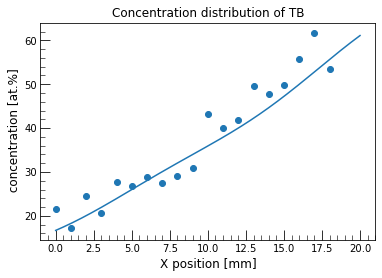

In [93]:
data=pd.read_excel("test.xlsx")
filename_poly='C:/Users/Frącek/Desktop/PyHist/polynomial_AK_97.npy'
value = concentration.optimization(data,filename_poly,"Tb","Co",20)

sample_2 = concentration("Tb", "Co", value, 100, filename_poly)
sample_2.calculate_concentration_1D()
sample_2.draw_figures_1D()

font=12
plt.figure(0)
plt.scatter(data.index,data.iloc[:,1])
plt.title("Concentration distribution of TB",fontsize=font)
plt.xlabel("X position [mm]",fontsize=font)
plt.ylabel(" concentration [at.%]",fontsize=font)
plt.minorticks_on()
plt.tick_params(axis="both", which = "major", length=10, direction ="in",labelsize=10)
plt.tick_params(axis="both", which = "minor", length=5, direction ="in")


In [92]:
class App_window():
    
    def __init__(self, concentration):

        self.concentration = concentration
        
        #root initialization
        self.root = tk.Tk()
        self.root.title("Concentration distribution by Łukasz Frąckowiak")
        self.root.geometry("1200x800")
        self.root.resizable(False, False)
        #cordinations initialization
        self.x, self.y = 0.02, 0.05
        self.x2=0.15
        
        self.mol_data = dict(pd.read_excel("molecular_database.xlsx"))
        
        self.start_frame()
        self.create_field()
        self.root.mainloop()
        
        
     
    def start_frame(self):
        self.text = tk.Label(text="Below, please provide information about alloy sample", font=("", 10))
        self.text.place(relx=self.x, rely=self.y)
        
        self.button_exit = tk.Button(text="EXIT", command = self._exit)
        self.button_exit.place(relx=0.9, rely=self.y)
        
        self.button_calculate = tk.Button(text="Calculate", command = self.calculate)
        self.button_calculate.place(relx=0.6, rely=self.y)

    def create_field(self):
        
        self.text_elements = tk.Label(text="Name of elements", font=("", 10))
        self.text_elements.place(relx=self.x, rely=self.y+0.15)
        self.combobox_element1 = Combobox(values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_element1.place(relx= self.x2, rely= self.y+0.15)
        
        self.combobox_element2 = Combobox(values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_element2.place(relx= self.x2+0.05, rely= self.y+0.15)
        
        self.text_AK = tk.Label(text="A-K height [cm]", font=("", 10))
        self.text_AK.place(relx=self.x, rely=self.y+0.3)
        self.button_AK = tk.Button(text = "Load .npy file", command=self.load)
        self.button_AK.place(relx=self.x2, rely=self.y+0.3)
        
        self.text_thickness = tk.Label(text="Alloy thickness [A]", font=("", 10))
        self.text_thickness.place(relx=self.x, rely=self.y+0.45)        
        self.entry_thickness = tk.Entry(width=10)
        self.entry_thickness.place(relx= self.x2, rely= self.y+0.45)
        
        self.text_concentration = tk.Label(text="Concentration [at.%]", font=("", 10))
        self.text_concentration.place(relx=self.x, rely=self.y+0.6)        
        self.entry_concentration = tk.Entry(width=10)
        self.entry_concentration.place(relx= self.x2, rely= self.y+0.6)
        
        
    def load(self):
            self.filename = fd.askopenfilename(filetypes =[('NumPy File', '*.npy')])
            self.text_filename = tk.Label(text=f"{self.filename}", font=("", 10))
            self.text_filename.place(relx=0, rely=self.y+0.35)
    
    def calculate(self):
        self.sample = concentration(self.combobox_element1.get(),self.combobox_element2.get(),self.entry_concentration.get(),self.entry_thickness.get(),self.filename)
        self.sample.calculate_concentration_2D()
        self.sample.draw_figures_2D()

        xwidth, ywidth = 400,300
        
        canvas_comp_dist = FigureCanvasTkAgg(self.sample.fig[0])  # A tk.DrawingArea.
        canvas_comp_dist.draw()
        canvas_comp_dist.get_tk_widget().place(relx=0.3, rely=0.15)
        canvas_comp_dist.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_comp = FigureCanvasTkAgg(self.sample.fig[1])  # A tk.DrawingArea.
        canvas_comp.draw()
        canvas_comp.get_tk_widget().place(relx=0.65, rely=0.15)
        canvas_comp.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_thickness_dist = FigureCanvasTkAgg(self.sample.fig[2])  # A tk.DrawingArea.
        canvas_thickness_dist.draw()
        canvas_thickness_dist.get_tk_widget().place(relx=0.3, rely=0.55)
        canvas_thickness_dist.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_thickness = FigureCanvasTkAgg(self.sample.fig[3])  # A tk.DrawingArea.
        canvas_thickness.draw()
        canvas_thickness.get_tk_widget().place(relx=0.65, rely=0.55)
        canvas_thickness.get_tk_widget().configure(width=xwidth,height=ywidth)         
       
        
    def _exit(self):
        self.root.quit()  # stops mainloop
        self.root.destroy()  # this is necessary on Windows to preven


App_window(concentration)

In [9]:
from tkinter import *
from tkinter import ttk

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Frącek\AppData\Local\Temp\ipykernel_8888\3363150912.py", line 152, in calculate_frame_2
    canvas_comp.get_tk_widget().configure(width=xwidth,height=ywidth)
NameError: name 'xwidth' is not defined


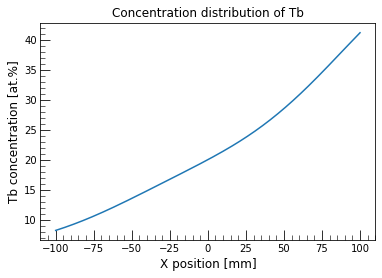

In [70]:
class App_window():
    
    def __init__(self, concentration):

        self.concentration = concentration
        
        #root initialization
        self.root = tk.Tk()
        self.root.title("Concentration distribution by Łukasz Frąckowiak")
        self.root.geometry("1200x800")
        self.root.resizable(False, False)
        
        #tabs and frame initialization
        self.tab = ttk.Notebook(self.root)
        
        self.page1=tk.Frame(self.tab)
        self.tab.add(self.page1, text = "Numerical model calculation")
        
        self.page2=tk.Frame(self.tab)
        self.tab.add(self.page2, text = "Fit to numerical model")
        
        self.tab.pack(fill="both", expand=1)
        #self.page1.pack(fill="both", expand=1)
        
        
        
        #cordinations initialization
        self.x, self.y = 0.02, 0.05
        self.x2=0.15
        
        self.mol_data = dict(pd.read_excel("molecular_database.xlsx"))
        
        
        self.start_frame_1()
        self.start_frame_2()
        self.root.mainloop()
        
        
     
    def start_frame_1(self):
        self.text = tk.Label(master=self.page1,text="Below, please provide information about alloy sample", font=("", 10))
        self.text.place(relx=self.x, rely=self.y)
        
        self.button_exit = tk.Button(master=self.page1, text="EXIT", command = self._exit)
        self.button_exit.place(relx=0.9, rely=self.y)
        
        self.button_calculate = tk.Button(master=self.page1, text="Calculate", command = self.calculate_frame_1)
        self.button_calculate.place(relx=0.6, rely=self.y)
        
        self.text_Elements = tk.Label(master=self.page1, text="Name of elements", font=("", 10))
        self.text_Elements.place(relx=self.x, rely=self.y+0.15)
        self.combobox_Element1 = Combobox(master=self.page1, values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_Element1.place(relx= self.x2, rely= self.y+0.15)
        
        self.combobox_Element2 = Combobox(master=self.page1, values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_Element2.place(relx= self.x2+0.05, rely= self.y+0.15)
        
        self.text_AK = tk.Label(master=self.page1, text="A-K height [cm]", font=("", 10))
        self.text_AK.place(relx=self.x, rely=self.y+0.3)
        self.button_AK = tk.Button(master=self.page1, text = "Load .npy file", command=self.load_poly)
        self.button_AK.place(relx=self.x2, rely=self.y+0.3)
        
        self.text_thickness = tk.Label(master=self.page1, text="Alloy thickness [A]", font=("", 10))
        self.text_thickness.place(relx=self.x, rely=self.y+0.45)        
        self.entry_thickness = tk.Entry(master=self.page1, width=10)
        self.entry_thickness.place(relx= self.x2, rely= self.y+0.45)
        
        self.text_concentration = tk.Label(master=self.page1, text="Concentration [at.%]", font=("", 10))
        self.text_concentration.place(relx=self.x, rely=self.y+0.6)        
        self.entry_concentration = tk.Entry(master=self.page1,width=10)
        self.entry_concentration.place(relx= self.x2, rely= self.y+0.6)
       
    def load_poly(self):
            self.filename_poly = fd.askopenfilename(filetypes =[('NumPy File', '*.npy')])
            self.text_filename_poly = tk.Label(master=self.page1, text=f"{self.filename_poly}", font=("", 10))
            self.text_filename_poly.place(relx=0, rely=self.y+0.35)
    
    def calculate_frame_1(self):
        self.sample = concentration(self.combobox_Element1.get(),self.combobox_Element2.get(),self.entry_concentration.get(),self.entry_thickness.get(),self.filename)
        self.sample.calculate_concentration_2D()
        self.sample.draw_figures_2D()

        xwidth, ywidth = 400,300
        
        canvas_comp_dist = FigureCanvasTkAgg(master=self.page1, figure=self.sample.fig[0])  # A tk.DrawingArea.
        canvas_comp_dist.draw()
        canvas_comp_dist.get_tk_widget().place(relx=0.3, rely=0.15)
        canvas_comp_dist.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_comp = FigureCanvasTkAgg(master=self.page1, figure=self.sample.fig[1])  # A tk.DrawingArea.
        canvas_comp.draw()
        canvas_comp.get_tk_widget().place(relx=0.65, rely=0.15)
        canvas_comp.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_thickness_dist = FigureCanvasTkAgg(master=self.page1, figure=self.sample.fig[2])  # A tk.DrawingArea.
        canvas_thickness_dist.draw()
        canvas_thickness_dist.get_tk_widget().place(relx=0.3, rely=0.55)
        canvas_thickness_dist.get_tk_widget().configure(width=xwidth,height=ywidth)
        
        canvas_thickness = FigureCanvasTkAgg(master=self.page1, figure=self.sample.fig[3])  # A tk.DrawingArea.
        canvas_thickness.draw()
        canvas_thickness.get_tk_widget().place(relx=0.65, rely=0.55)
        canvas_thickness.get_tk_widget().configure(width=xwidth,height=ywidth)         

    def start_frame_2(self):
        self.text = tk.Label(master=self.page2,text="Below, please provide information about alloy sample", font=("", 10))
        self.text.place(relx=self.x, rely=self.y)
        
        self.button_exit = tk.Button(master=self.page2, text="EXIT", command = self._exit)
        self.button_exit.place(relx=0.9, rely=self.y)
        
        self.button_calculate_2 = tk.Button(master=self.page2, text="Calculate", command = self.calculate_frame_2)
        self.button_calculate_2.place(relx=0.6, rely=self.y)
        
        self.text_Elements = tk.Label(master=self.page2, text="Name of elements", font=("", 10))
        self.text_Elements.place(relx=self.x, rely=self.y+0.15)
        self.combobox_Element1 = Combobox(master=self.page2, values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_Element1.place(relx= self.x2, rely= self.y+0.15)
        
        self.combobox_Element2 = Combobox(master=self.page2, values=list(self.mol_data.keys())[1:], state = "readonly",width=5)
        self.combobox_Element2.place(relx= self.x2+0.05, rely= self.y+0.15)
        
        self.text_AK = tk.Label(master=self.page2, text="A-K height [cm]", font=("", 10))
        self.text_AK.place(relx=self.x, rely=self.y+0.3)
        self.button_AK = tk.Button(master=self.page2, text = "Load .npy file", command=self.load_poly)
        self.button_AK.place(relx=self.x2, rely=self.y+0.3)
        

        self.button_AK = tk.Button(master=self.page2, text = "Load excel data file", command=self.load_data)
        self.button_AK.place(relx=self.x2, rely=self.y+0.45)        
        
    def load_data(self):
            self.filename_data = fd.askopenfilename(filetypes =[('Excel Data File', '*.xlsx')])
            self.text_filename_data = tk.Label(master=self.page2, text=f"{self.filename_data}", font=("", 10))
            self.text_filename_data.place(relx=0, rely=self.y+0.5)
            
    def calculate_frame_2(self):
        
        Element1 = self.combobox_Element1.get()
        Element2 = self.combobox_Element2.get()
        
        data = pd.read_excel(self.filename_data)
        value = concentration.optimization(data,self.filename_poly,Element1,Element2)
        value=20
        self.sample_2 = concentration(Element1, Element2, value, 100,self.filename_poly)
        self.sample_2.calculate_concentration_1D()
        self.sample_2.draw_figures_1D()
        
        canvas_comp = FigureCanvasTkAgg(master=self.page2, figure=self.sample_2.fig[0])  # A tk.DrawingArea.
        canvas_comp.draw()
        canvas_comp.get_tk_widget().place(relx=0.65, rely=0.15)
        canvas_comp.get_tk_widget().configure(width=xwidth,height=ywidth)
    def _exit(self):
        self.root.quit()  # stops mainloop
        self.root.destroy()  # this is necessary on Windows to prevent


App_window(concentration)